In [1]:
from visualization.plotting import plot_img_mask_heatmap
from xai.embedded_gradcam.database import build_database
from xai.embedded_gradcam.gradcam import generate_activations
from xai.embedded_gradcam.helpers import _plot_grad_heatmap
from xai.metrics.top_k_intersections import TopKIntersection
from xai.embedded_gradcam.embedded_gradcam import read_database, explain_batch, explain_image

from models.bolts import load_vqvae
from datasets.datautils import extract_data_loader
from datasets.two4two import Two4TwoDataModule


import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("Using CPU")

Global seed set to 42


Using CPU
Using CPU
Using CPU
Using CPU


In [2]:
seed = 42
import numpy as np
np.random.seed(seed)
import torch
torch.manual_seed(seed)

In [3]:
import matplotlib
# set colormap to RdBu_r
matplotlib.rcParams['image.cmap'] = 'bwr'

In [18]:
data_path = "/home/jonasklotz/Studys/23SOSE/XAI_in_SSL/data/two4two_small"
work_path = "/home/jonasklotz/Studys/23SOSE/XAI_in_SSL/results/gradcam"
model_path = '/home/jonasklotz/Studys/23SOSE/XAI_in_SSL/results/models/bolt_vae.ckpt'
database_path = "/home/jonasklotz/Studys/23SOSE/XAI_in_SSL/results/gradcam/database"

In [19]:
model = load_vqvae(input_height=128, input_channels=3)
model = model.load_from_checkpoint(model_path, map_location=device)

/home/jonasklotz/Studys/23SOSE/XAI_in_SSL/src/models/bolts.py:14: UnderReviewWarning: The feature VAE is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  vae = VAE(input_height=input_height, **kwargs)
/home/jonasklotz/Environment/miniconda3/envs/XAI_in_SSL/lib/python3.10/site-packages/pl_bolts/models/autoencoders/basic_vae/basic_vae_module.py:93: UnderReviewWarning: The feature resnet18_encoder is currently marked under review. The compatibility with other Lightning projects is not guaranteed and API may change at any time. The API and functionality may change without warning in future releases. More details: https://lightning-bolts.readthedocs.io/en/latest/stability.html
  self.encoder = valid_encoders[enc_type]["enc"](first_conv, maxpool1)
/home/jonasklot

In [20]:
data_module = Two4TwoDataModule(data_dir=data_path, working_path=work_path, batch_size=1)
encoder = model.encoder
layer = encoder.layer4[1].conv2

In [32]:
encoder


ResNetEncoder(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): EncoderBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): EncoderBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inpla

# Embedding GradCAM

In [23]:
database_path = "/home/jonasklotz/Studys/23SOSE/XAI_in_SSL/results/gradcam/database"
embeddings_db, gradients_db = read_database(database_path)
print(embeddings_db.shape, gradients_db.shape)

(2679, 512) (2679, 512)


In [24]:
# load batch of 64 images from test set
data_module = Two4TwoDataModule(data_dir=data_path, working_path=work_path, batch_size=64)
data_loader = extract_data_loader(data_module, "test")
#x_batch, s_batch, y_batch = next(iter(data_loader))


In [ ]:
for x_batch, s_batch, y_batch in data_loader:
    

In [31]:
metric = TopKIntersection(k=10, return_aggregate=True)

batch_eval = metric(x_batch=x_batch, s_batch=s_batch, a_batch=a_batch)

print(batch_eval)
print("done")

[1.4671874999999999]
done


In [25]:
# get heatmaps for batch
a_batch = explain_batch(model, encoder, layer, embeddings_db, gradients_db, x_batch, save_path=work_path,
                        plot=False)

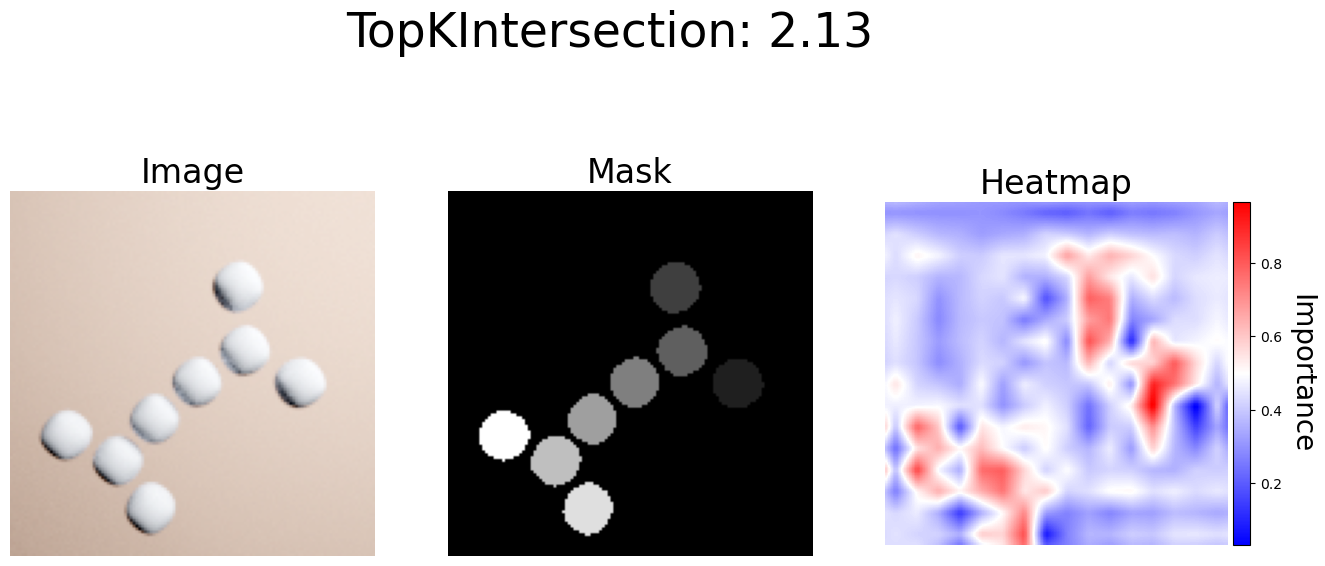

In [25]:
i = 0
metric = TopKIntersection(k=100, return_aggregate=True)
from visualization.plotting import plot_img_mask_heatmap
# convert all to numpy
img = x_batch[i].detach().cpu().numpy()
label = y_batch[i].detach().cpu().numpy()
mask = s_batch[i].detach().cpu().numpy()
heatmap = a_batch[i]
eval = metric.evaluate_instance(model, img, label, heatmap, mask)
title = f"TopKIntersection: {eval}"
plot_img_mask_heatmap(x_batch[i], s_batch[i], a_batch[i], title=title, save_path=work_path, save=True)


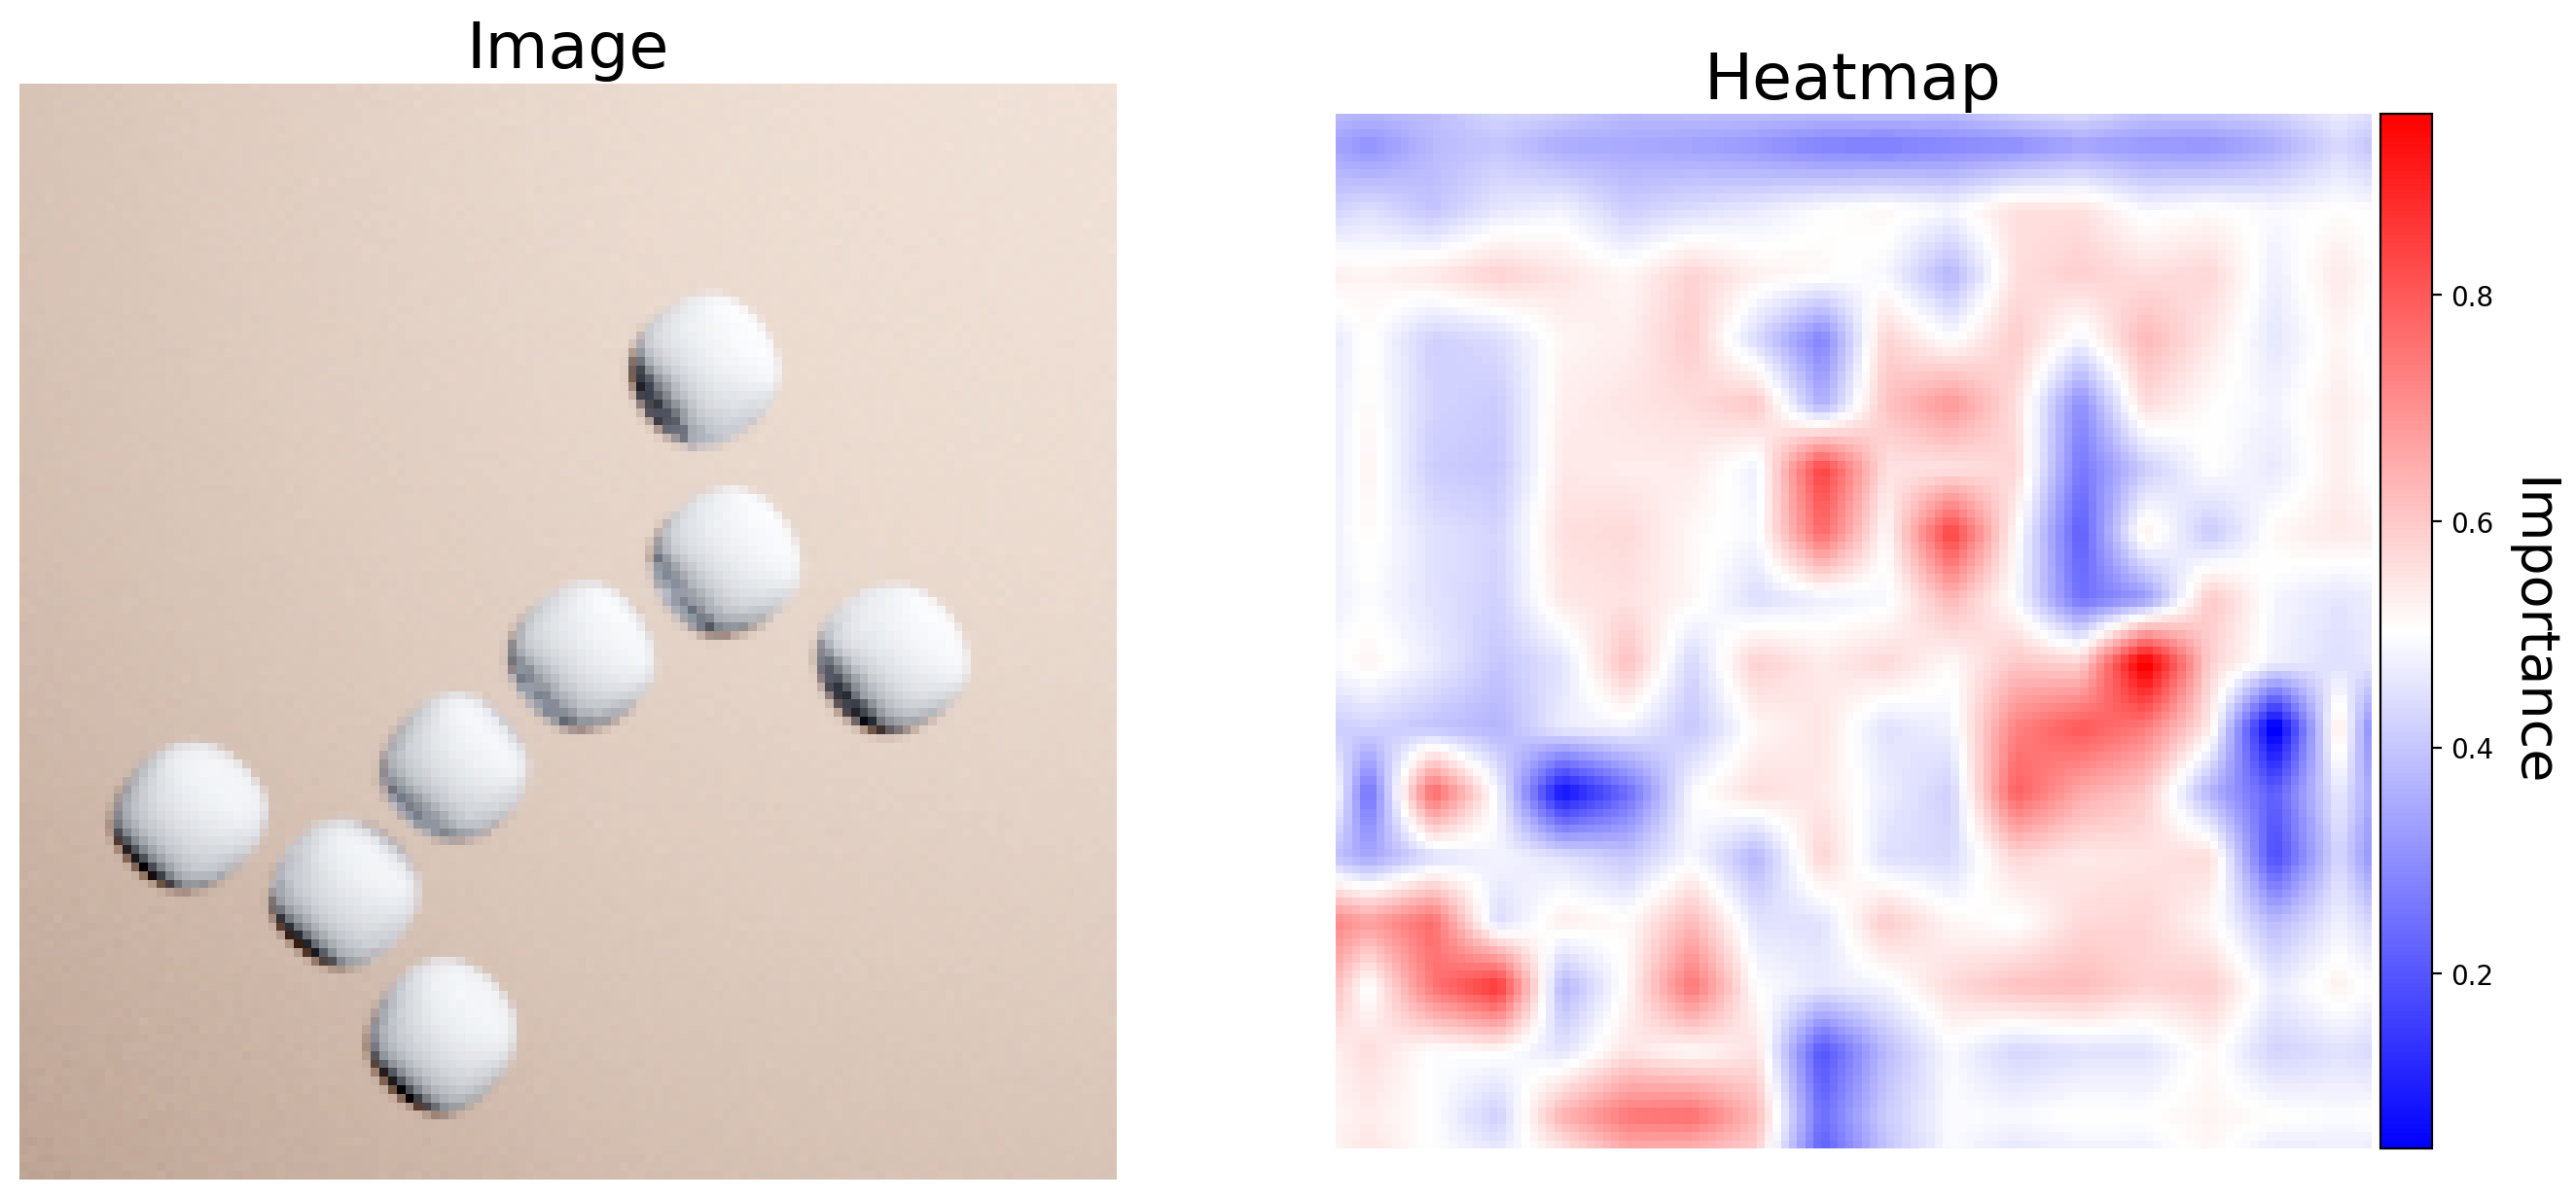

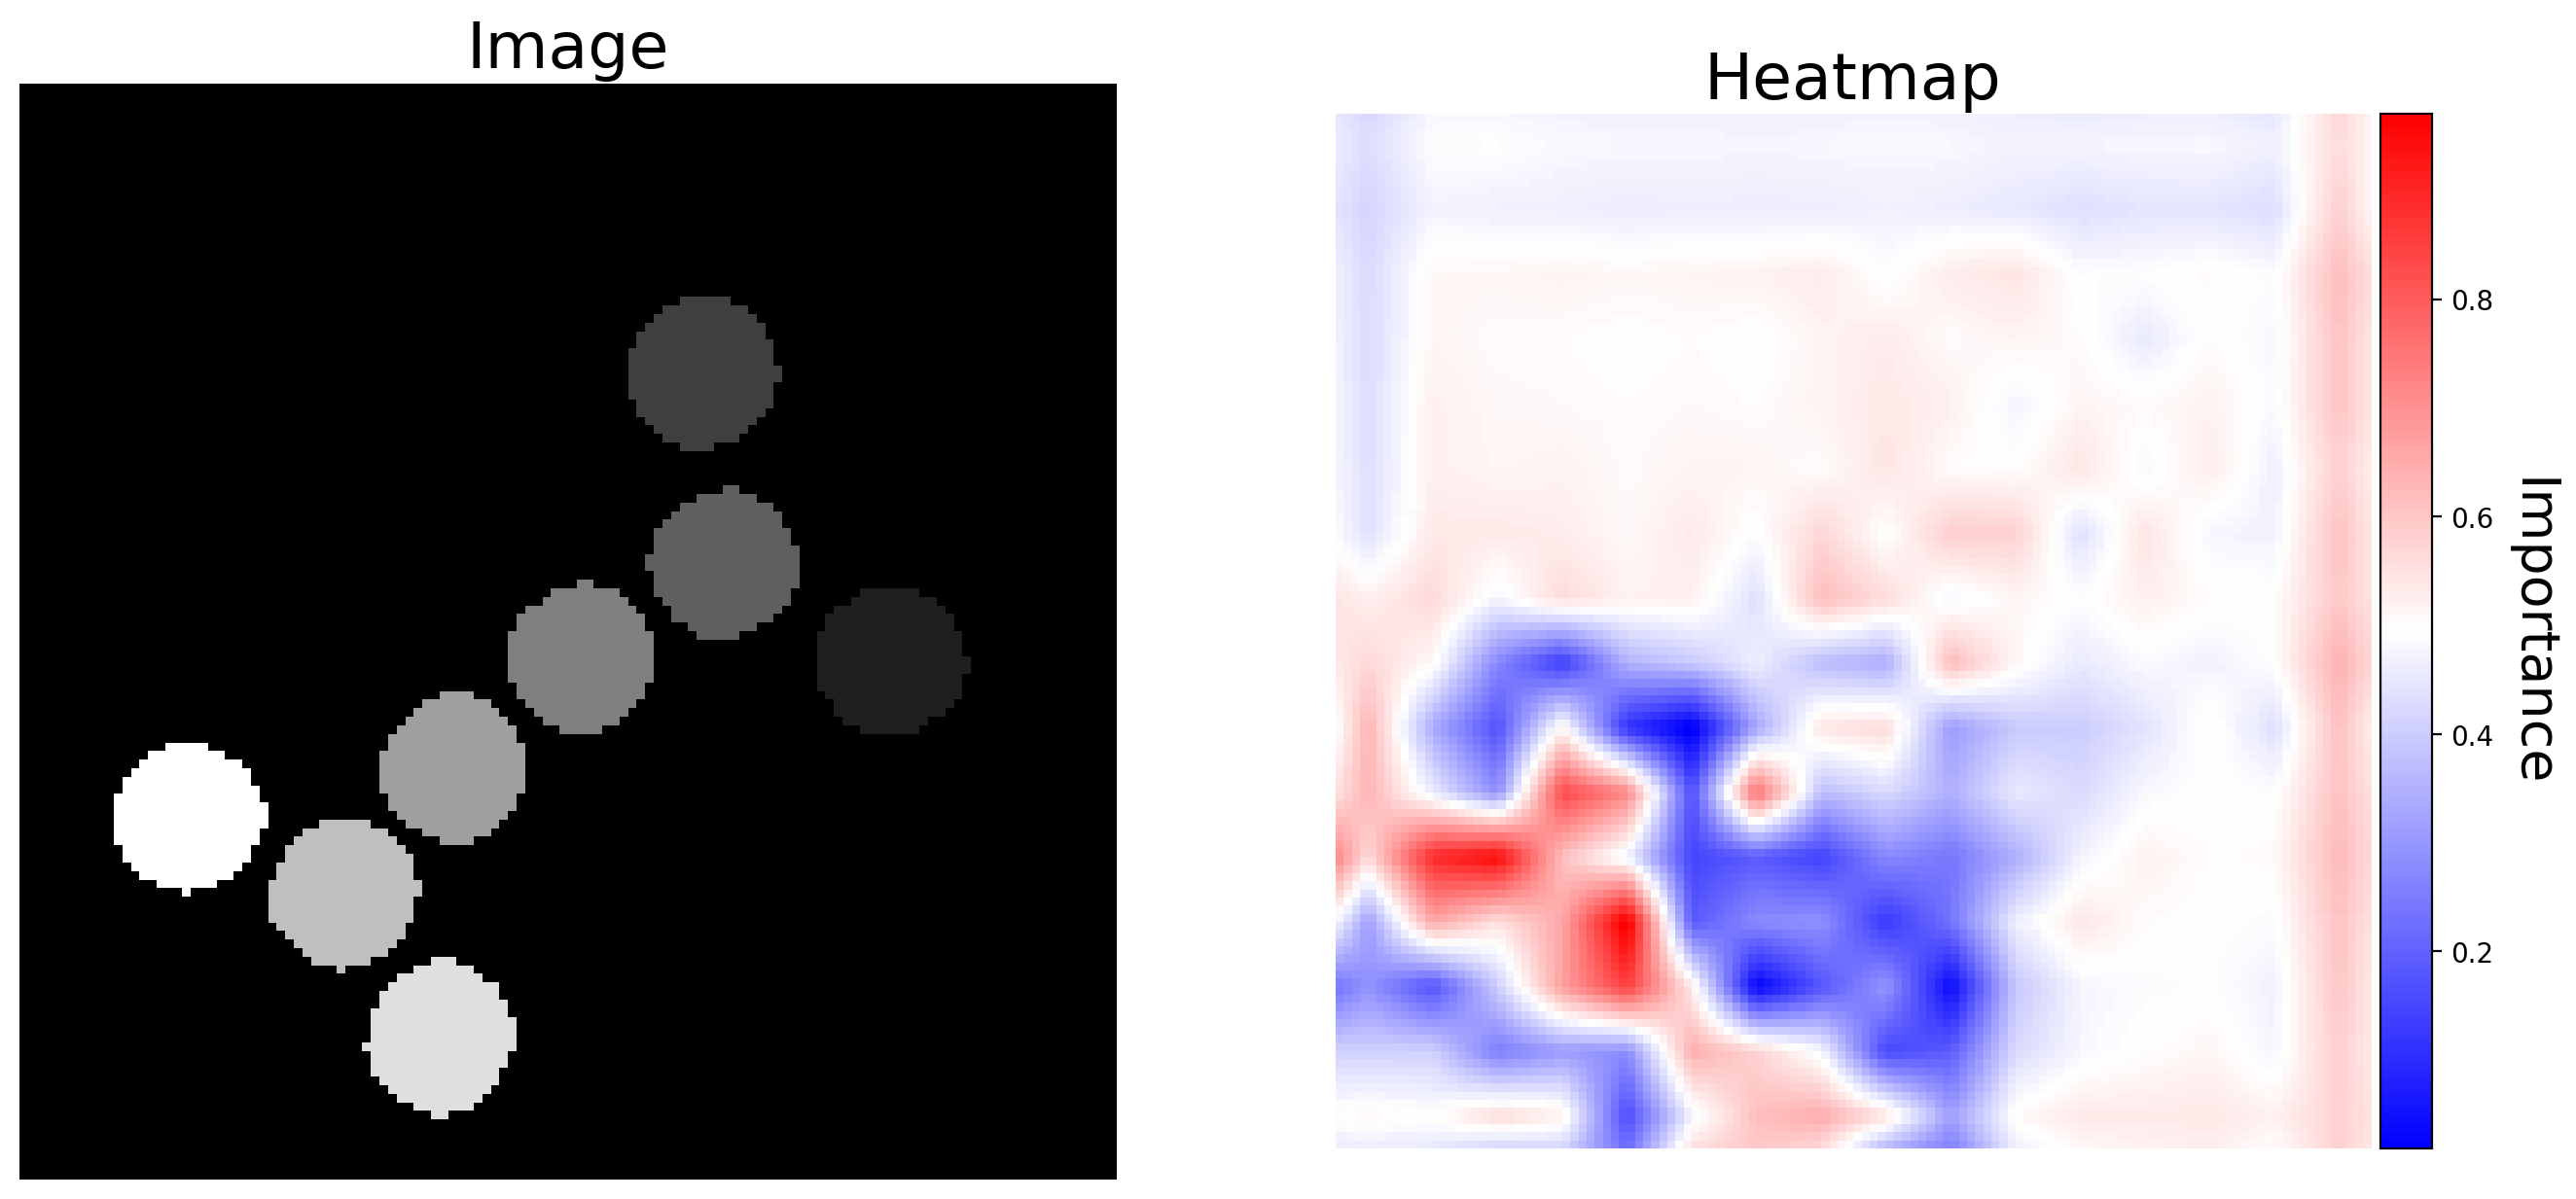

In [9]:
i =0
save_path = '/home/jonasklotz/Studys/23SOSE/XAI_in_SSL/results/gradcam/plots'
from xai.embedded_gradcam.embedded_gradcam import read_database, explain_batch, explain_image

heatmap = explain_image(x_batch[i], model, encoder, layer, embeddings_db, gradients_db, save_path=save_path)
heatmap = explain_image(s_batch[i], model, encoder, layer, embeddings_db, gradients_db, save_path=save_path)

NameError: name 'a_batch' is not defined

# Visualizing Deep Similarity Images

In [7]:
from visualization.vsdn import load_zarr_embeddings, explain_image
from datasets.datautils import sample_from_data_module

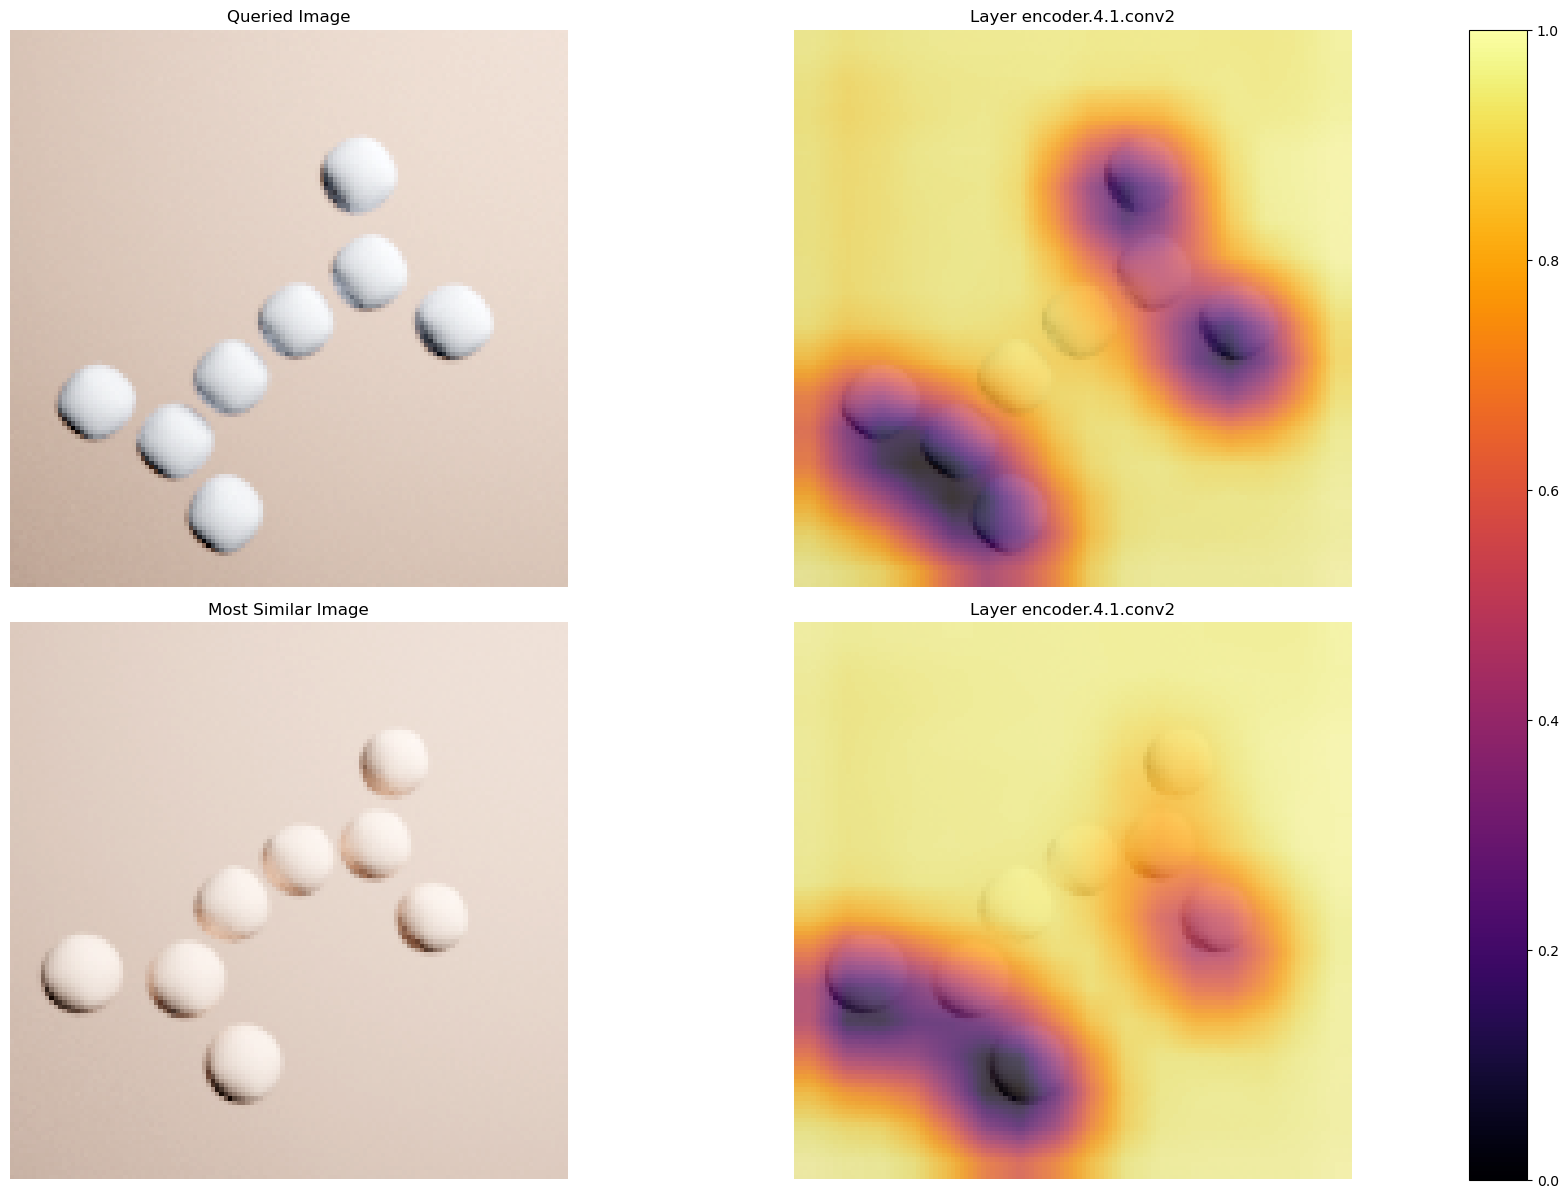

In [8]:
database_path = "/home/jonasklotz/Studys/23SOSE/XAI_in_SSL/results/vsdn/database"

# get query images
query_imgs, _, _ = sample_from_data_module(data_module, stage='test')
query_img = query_imgs[0].unsqueeze(0)

# visualize_reconstructions(model, query_imgs[:4])
ds_imgs, ds_embeddings = load_zarr_embeddings(database_path)
explain_image(query_img, ds_imgs, ds_embeddings, encoder, device)

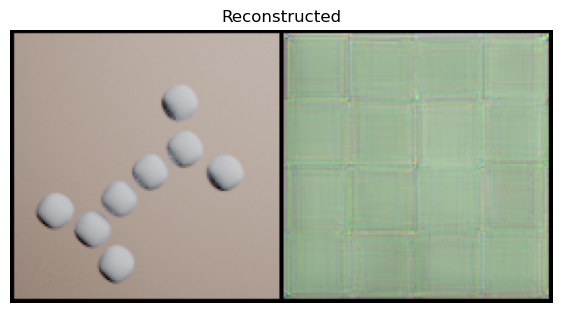

In [12]:
from visualization.plotting import visualize_reconstructions

visualize_reconstructions(model, query_imgs[:4])